## Using Pystan to fit Model 4. 
### Accessibility with Household and transportation costs (% of income) with random intercepts and slopes, and group level ethnicity predictors

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo. Stan is useful in very high dimensional problems, where there are a large numbers of predictors to infer. In this instance we have over 16,000 rows of data so therefore using Stan's computationally efficient sampling strategies is appropriate.

In [1]:
%matplotlib inline
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pickle
import fiona
import seaborn as sns
#import libpysal
import pysal
#import mapclassify as mc
import shapely
from shapely.geometry import Point, Polygon, LineString
sns.set(style="ticks", palette="muted", color_codes=True)

pd.options.display.max_rows = 10

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


In [3]:
Lag_pred_for_merge = pd.read_csv('Lag_pred_for_merge.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Lag_pred_for_merge['GEOID10']=Lag_pred_for_merge['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Lag_pred_for_merge.head()

,Unnamed: 0,GEOID10,populati_1,yb,lag_ht_ami,lag_Lowest_Qui,lag_Hispanic,lag_Black_Afri,lag_White_Alon,lag_Less_high_,...,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_0_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,060371011101000,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,9441.088,89468.05,96512.68,77364.130,80264.734
1,2,060371011101007,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10524.009,89468.05,96512.68,77364.130,80264.734
2,3,060371011101008,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10315.592,89468.05,96512.68,77364.130,80264.734
3,4,060371011101011,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10270.440,89468.05,96512.68,77364.130,80264.734
4,5,060371011102004,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,11573.969,93797.41,104498.48,83827.266,88984.016


In [4]:
All_data = Data_clean_all_col.merge(Lag_pred_for_merge,
                                    on='GEOID10')
All_data.head()

,Unnamed: 0_x,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_0_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,9441.088,89468.05,96512.68,77364.130,80264.734
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10524.009,89468.05,96512.68,77364.130,80264.734
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10315.592,89468.05,96512.68,77364.130,80264.734
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10270.440,89468.05,96512.68,77364.130,80264.734
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,11573.969,93797.41,104498.48,83827.266,88984.016


We also need a lookup table (`list`) for each unique block, block group and tract, for indexing.

In [5]:
unique_blocks = All_data.BlockId.unique().tolist()
unique_bgs = All_data.BlockgroupId.unique().tolist()
unique_tracts = All_data.TractId.unique().tolist()

Then define the length of the lists for blocks, block groups and tracts. 

In [64]:
N = len(unique_blocks)
J = len(unique_bgs)
Q = len(unique_tracts)

### Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected accessibility value at the block level, specify another regression model with a tract-level covariate, such as the number of Black African Americans. Here, we use the percentage of Black African Americans ethnicity in each tract $u_j$, which is :

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a tract-level predictor (percentage Black African American) as well as a block group-level predictor (% income on household and transportation costs).

Note that the model has both indicator variables for each block group, plus a block group-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [65]:
block_to_bg = dict(All_data[['BlockId', 'BlockgroupId']].values)

In [66]:
block_to_bg_vector = [unique_bgs.index(bg) + 1 for bg in block_to_bg.values()]

Then create a dictionary to summarise block group variability at the tract level.

In [67]:
bg_to_tract = dict(All_data[['BlockgroupId', 'TractId']].values)

In [68]:
bg_to_tract_vector = [unique_tracts.index(tract) + 1 for tract in bg_to_tract.values()]

Compute the average level of the parameters at each level.

In [69]:
bglevel = All_data.groupby('BlockgroupId')\
                            [['ht_ami']].apply(np.mean).values

In [70]:
tractlevel = Data_clean_all_col.groupby('TractId')\
                            [['Black_Afri']].apply(np.mean).values

In [71]:
tractlevel_1 = Data_clean_all_col.groupby('TractId')\
                            [['Hispanic']].apply(np.mean).values

As there is no greater heirarchical level than the tract, we summarise like this.

In [72]:
tractlevel = np.zeros((Q,1))

In [ ]:
group_effects = """
data {
  int<lower=0> N; 
  int<lower=0> P_N; 
  int<lower=0> J; 
  int<lower=0> P_J; 
  int<lower=0> Q; 
  int<lower=0> P_Q; 
  int<lower=1, upper=J> block_to_bg[N];
  int<lower=1, upper=Q> bg_to_tract[J];
  vector[J] ht_ami;
  vector[Q] afam;
  vector[Q] hispan;
  vector[N] y;
} 
parameters {
  vector[J] bg_intercept;
  vector[Q] tract_intercept;
  real hypermean;
  vector[J] ht_ami_slope;
  vector[Q] afam_slope;
  vector[Q] hispan_slope;
  real<lower=0> sigma_block;
  real<lower=0> sigma_bg;
  real<lower=0> sigma_tract;
}
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = bg_intercept[block_to_bg[i]] 
               + ht_ami[block_to_bg[i]] * ht_ami_slope[block_to_bg[i]];
    
}
model {
  for (q in 1:Q)
    tract_intercept[q] ~ normal(hypermean, sigma_tract);
  for (j in 1:J)
    bg_intercept[j] ~ normal(tract_intercept[bg_to_tract[j]]
                             + afam[bg_to_tract[j]] * afam_slope[bg_to_tract[j]]
                             + hispan[bg_to_tract[j]] * hispan_slope[bg_to_tract[j]], 
                             sigma_bg);
  y ~ normal(y_hat, sigma_block);
}
"""

In [ ]:
data_for_model = dict(
    N = N,
    P_N = 1,
    J = J,
    P_J = 1,
    Q = Q,
    P_Q = 1,
    block_to_bg = block_to_bg_vector,
    bg_to_tract = bg_to_tract_vector,
    ht_ami = bglevel.flatten(),
    afam = tractlevel.flatten(),
    hispan = tractlevel_1.flatten(),
    y = Data_clean_all_col['Tot_r_10'].values
)

In [ ]:
sm4 = pystan.StanModel(model_code=group_effects)
fit4 = sm4.sampling(data=data_for_model, 
                    iter=6000, 
                    chains=4, warmup=500, 
                    thin=1, seed=101)

In [ ]:
with open('./stanmodel_slopes_and_intercepts_model_sm_4.pkl', 'wb') as outfile:
    pickle.dump(sm4, outfile)
with open('./stanmodel_slopes_and_intercepts_result_fit_4.pkl', 'wb') as outfile:
    pickle.dump(fit4, outfile)

In [6]:
import pickle 
with open('./Fit_4/stanmodel_slopes_and_intercepts_model_fit_4.pkl', 'rb') as infile:
    sm_4 = pickle.load(infile)

In [7]:
import pickle
with open('./Fit_4/stanmodel_slopes_and_intercepts_result_fit_4.pkl', 'rb') as infile:
    fit_4 = pickle.load(infile)

In [18]:
summary_dict = fit_4.summary()
fit4_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


fit4_df.head()
fit4_df.to_csv('./Fit_4/Predictions_IQR_4.csv')

In [16]:
# Extracting traces

sigma_block = fit_4['sigma_block']
sigma_bg = fit_4['sigma_bg']
sigma_tract = fit_4['sigma_tract']

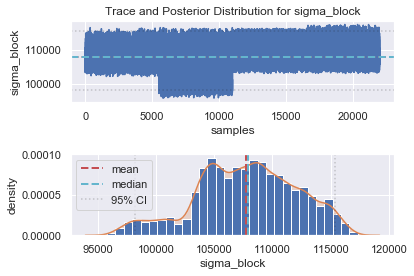

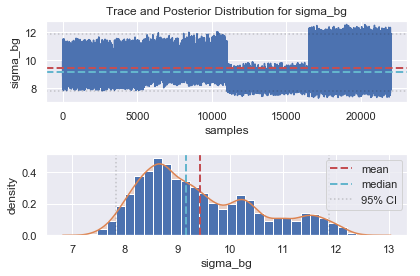

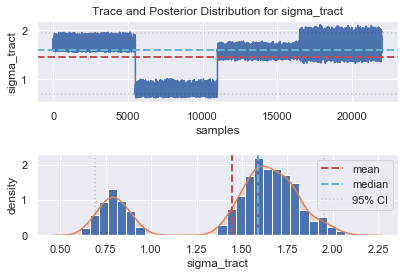

In [17]:
sns.set()

# Nice plot parameters
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#matplotlib.rc('text', usetex=True)


def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()


plot_trace(sigma_block, 'sigma_block') 
plt.show()
plot_trace(sigma_bg, 'sigma_bg') 
plt.show()
plot_trace(sigma_tract, 'sigma_tract') 
plt.show()

In [8]:
test_4 = fit_4.to_dataframe()

In [16]:
test_4.stansummary()

AttributeError: 'DataFrame' object has no attribute 'stansummary'

In [17]:
Df_mlm_4 = pystan.stansummary(fit_4).to_dataframe()

KeyboardInterrupt: 

In [14]:
Df_mlm_4.to_csv('./DF_MLM_4.csv')

AttributeError: 'str' object has no attribute 'to_csv'

In [9]:
test_4.head()

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,bg_intercept[1],...,y_hat[16462],y_hat[16463],y_hat[16464],y_hat[16465],y_hat[16466],y_hat[16467],y_hat[16468],y_hat[16469],y_hat[16470],lp__
0,1,1,0,0,216529.630074,10,0.944952,0.000325,1023,-38.602692,...,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-6796.600074,-210083.371974
1,1,2,0,0,216661.289496,10,0.886509,0.000325,1023,-39.136541,...,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-6820.474619,-210096.709501
2,1,3,0,0,216603.373042,10,0.981249,0.000325,1023,-39.650231,...,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-6868.209978,-210095.464055
3,1,4,0,0,216578.973788,10,0.896930,0.000325,1023,-40.365378,...,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-7147.438156,-210065.559726
4,1,5,0,0,216560.923693,10,0.831177,0.000325,1023,-40.540518,...,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-7162.649960,-210108.884445


In [ ]:
test_4.to_csv('./stanmodel_slopes_and_intercepts_fit4.csv')

In [ ]:
pred4 = test_4.loc[:,'y_hat[1]':'y_hat[16470]']


In [ ]:
pred4.to_csv('./Pred_fit4.csv')

In [ ]:
pred_2000_4 = test_4.loc[21999:21999,'y_hat[1]':'y_hat[16470]']
pred_2000_4

In [ ]:
pred_trans_4 = pred_2000_4.transpose()

In [58]:
predictions = pd.read_csv('./Fit_4/Pred_4_trans.csv')
predictions.head()

,Unnamed: 0,21999
0,y_hat[1],14641.369980
1,y_hat[2],14641.369980
2,y_hat[3],14641.369980
3,y_hat[4],14641.369980
4,y_hat[5],528.113892


In [59]:
y_pred = predictions['21999']
y_true = All_data['Tot_r_10']

In [60]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [61]:
r2(y_pred, y_true)

-1.9883613372636573

In [62]:
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

-1.9885427909850288

#### plotting Model 4 results

In [ ]:
fit4.traceplot('bg_intercept')

In [ ]:
fit4.traceplot('sigma_bg')

In [ ]:
fit4.traceplot('ht_ami_slope')

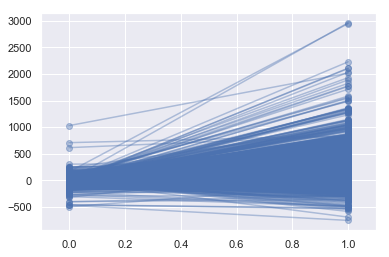

In [19]:
sns.set()
xvals = np.arange(2)
b = fit_4['bg_intercept'].mean(axis=0)
m = fit_4['ht_ami_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.plot(figsize=(50, 50))
plt.savefig("Multilevel_fit4_ht_ami.png", format="PNG")


In [21]:
fit_4['ht_ami_slope'].mean()

190.23970346622613

The estimate for the `ht_ami` coefficient is approximately 10.4, which can be interpreted as houses with over 10% of their income being spent on household and transportation costs having over more than the average accessibility to employment by private transportation (after 10 mins of travel time) of those with less than 10% of income spent on housing and transportation, after accounting for the block.

In [ ]:
fit4['tract_intercept'].mean()

In [6]:
xvals = np.arange(2)
bp = fit4['tract_intercept'].mean(axis=0)
mp = fit4['afam_slope'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);
plt.savefig("Multilevel_fit3_1_afam.png", format="PNG")


NameError: name 'fit4' is not defined

In [23]:
fit_4['afam_slope'].mean()

1.1246181503247346

The estimate for the `afam_slope` coefficient is approximately -3, which can be interpreted as for every unit increase in the level of accessibility (after 10 mins of travel time) there is, on average a decrease in the percentage of black african americans at the block level.

In [ ]:
xvals = np.arange(2)
b = fit4['tract_intercept'].mean(axis=0)
m = fit4['hispan_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit4_hispan.png", format="PNG")


In [24]:
fit_4['hispan_slope'].mean()

-2.6498199534571083

The estimate for the `hispan_slope` coefficient is approximately 2.2, which can be interpreted as for every unit increase in the level of accessibility (after 10 mins of travel time) there is, on average a 2% increase in the percentage of hispanics at the block level. However, this coefficient varies around 0 so this trend does not hold for all blocks.

In [7]:
import pickle
with open('./Fit_4/stanmodel_slopes_and_intercepts_model_fit_4.pkl', 'rb') as infile:
    sm_4 = pickle.load(infile)

In [8]:

with open('./Fit_4/stanmodel_slopes_and_intercepts_result_fit_4.pkl', 'rb') as infile:
    fit_4 = pickle.load(infile)

In [75]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain, sigma_ht_ami_chain, sigma_afam_chain, sigma_hispan_chain = fit_4.extract(['sigma_block', 'sigma_bg', 'sigma_tract', 'ht_ami_slope', 'afam_slope', 'hispan_slope']).values()

In [76]:
sigma_b = sigma_b_chain.mean()
sigma_bg = sigma_bg_chain.mean()
sigma_t = sigma_t_chain.mean()
sigm_ht_ami = sigma_ht_ami_chain.mean()
sigma_afam = sigma_afam_chain.mean()
sigma_hipsan = sigma_hispan_chain.mean()


In [77]:
print(sigma_b, sigma_bg, sigma_t, sigm_ht_ami, sigma_afam, sigma_hipsan)

107762.22545940167 9.422938296130788 1.4456978701798235 190.23970346622613 1.1246181503247346 -2.6498199534571083


In [28]:
sigma_b = sigma_b_chain[-500:].mean()
sigma_bg = sigma_bg_chain[-500:].mean()
sigma_t = sigma_t_chain[-500:].mean()

In [21]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain = fit_4.extract(['sigma_block', 'sigma_bg', 'sigma_tract']).values()

In [22]:
block_to_bg_dummies = pd.get_dummies(block_to_bg_vector).values
bg_to_tract_dummies = pd.get_dummies(bg_to_tract_vector).values

In [23]:
block_to_bg_dummies.shape

(16470, 3221)

In [24]:
from scipy import sparse

In [25]:
block_to_bg_sparse = sparse.csc_matrix(block_to_bg_dummies)
bg_to_tract_sparse = sparse.csc_matrix(bg_to_tract_dummies)

In [29]:
full_cov = sparse.identity(len(block_to_bg_vector)) * sigma_b**2 \
           + block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2

In [30]:
diag = full_cov.diagonal()

In [31]:
under_diag = diag**-.5

In [32]:
n = len(block_to_bg_vector)

In [34]:
full_correlation = sparse.identity(n).multiply(under_diag)\
                   @ (full_cov)\
                   @ sparse.identity(n).multiply(under_diag)

In [35]:
np.unique(full_correlation.data).round(10)

array([2.0e-10, 8.8e-09, 1.0e+00])

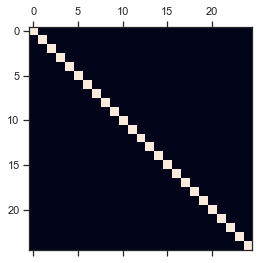

In [38]:
plt.matshow(full_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_4_bg.png')

# Disregarding block variation

In [39]:
partial_cov = block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2
           #+ sparse.identity(len(block_to_bg_vector)) * sigma_b \

In [40]:
partial_diag = partial_cov.diagonal() ** -.5

In [41]:
partial_correlation = sparse.identity(n).multiply(partial_diag)\
                       @ (partial_cov)\
                       @ sparse.identity(n).multiply(partial_diag)

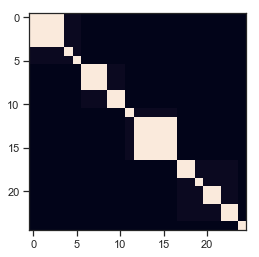

In [42]:
plt.imshow(partial_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_4_no_bg.png')

In [43]:
np.unique(partial_correlation.data)

array([0.02768832, 1.        ])

In [44]:
print(sigma_b**2, sigma_bg**2, sigma_t**2)

11965778046.64982 102.55244258646484 2.9203652561660247


# Catterpillar plot

In [45]:
test_4 = fit_4.to_dataframe('ht_ami_slope')

In [47]:
bg_stats = test_4.median().filter(like='ht_').to_frame('median')
bg_stats['top'] = test_4.quantile(.975).filter(like='ht_')
bg_stats['bottom'] = test_4.quantile(.025).filter(like='ht_')

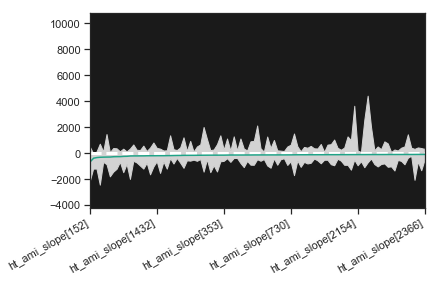

In [50]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-500,5000)
plt.savefig("fit_4_catterpillar_ht_ami_slope.png", format="PNG")

In [53]:
test_4_1 = fit_4.to_dataframe('afam_slope')

In [54]:
bg_stats = test_4_1.median().filter(like='af').to_frame('median')
bg_stats['top'] = test_4_1.quantile(.975).filter(like='af')
bg_stats['bottom'] = test_4_1.quantile(.025).filter(like='af')

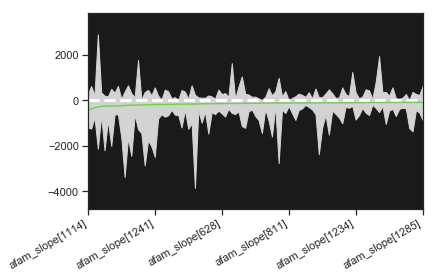

In [55]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#73D055', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-500,5000)
plt.savefig("fit_4_catterpillar_afam_slope.png", format="PNG")

In [56]:
test_4_2 = fit_4.to_dataframe('hispan_slope')

In [57]:
bg_stats = test_4_2.median().filter(like='hi').to_frame('median')
bg_stats['top'] = test_4_2.quantile(.975).filter(like='hi')
bg_stats['bottom'] = test_4_2.quantile(.025).filter(like='hi')

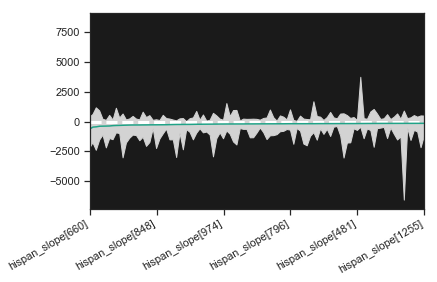

In [58]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-500,5000)
plt.savefig("fit_4_catterpillar_hispan_slope.png", format="PNG")

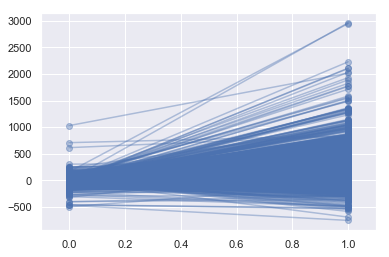

In [11]:
xvals = np.arange(2)
b = fit_4['bg_intercept'].mean(axis=0)
m = fit_4['ht_ami_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit4.png", format="PNG")


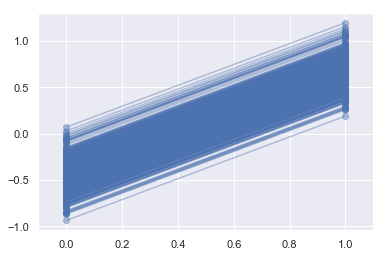

In [12]:
sns.set()
xvals = np.arange(2)
bp = fit_4['tract_intercept'].mean(axis=0)
mp = fit_4['afam_slope'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);
plt.savefig("Multilevel_fit3_1_afam.png", format="PNG")


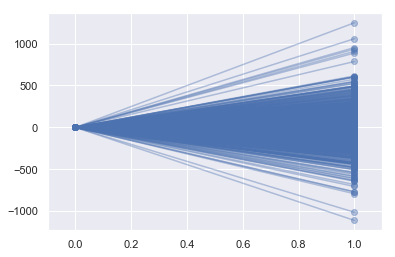

In [14]:
xvals = np.arange(2)
b = fit_4['tract_intercept'].mean(axis=0)
m = fit_4['hispan_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit4_hispan.png", format="PNG")
